In [1]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Housing.csv')
df.shape

(75388, 23)

In [3]:
df.columns

Index(['SERIAL', 'DENSITY', 'OWNERSHP', 'OWNERSHPD', 'COSTELEC', 'COSTGAS',
       'COSTWATR', 'COSTFUEL', 'HHINCOME', 'ROOMS', 'BUILTYR2', 'BEDROOMS',
       'VEHICLES', 'NFAMS', 'NCOUPLES', 'PERNUM', 'PERWT', 'AGE', 'MARST',
       'BIRTHYR', 'EDUC', 'EDUCD', 'INCTOT'],
      dtype='object')

# DATA SUBSETTING

In [4]:
# Consider only elder person rows for every household
data = df.sort_values(['SERIAL', 'AGE'], ascending=[True, False]).drop_duplicates('SERIAL')
data.shape

(30802, 23)

In [5]:
#Dropping the columns that seems not necessary
data = data.drop(['SERIAL', 'OWNERSHPD', 'PERNUM', 'PERWT', 'BIRTHYR', 'EDUC', 'EDUCD'], axis=1)

In [6]:
# checking for any NULL Values
data.isnull().any(axis=1).sum()

0

In [7]:
data.columns

Index(['DENSITY', 'OWNERSHP', 'COSTELEC', 'COSTGAS', 'COSTWATR', 'COSTFUEL',
       'HHINCOME', 'ROOMS', 'BUILTYR2', 'BEDROOMS', 'VEHICLES', 'NFAMS',
       'NCOUPLES', 'AGE', 'MARST', 'INCTOT'],
      dtype='object')

In [8]:
data['MARST'] = data['MARST'].replace({1: 'Married SP', 2: 'Married SA', 3: 'Separated', 4: 'Divorced', 5:'Widowed', 6: 'Never married'})
data = pd.get_dummies(data, columns=['MARST'])
data.columns

Index(['DENSITY', 'OWNERSHP', 'COSTELEC', 'COSTGAS', 'COSTWATR', 'COSTFUEL',
       'HHINCOME', 'ROOMS', 'BUILTYR2', 'BEDROOMS', 'VEHICLES', 'NFAMS',
       'NCOUPLES', 'AGE', 'INCTOT', 'MARST_Divorced', 'MARST_Married SA',
       'MARST_Married SP', 'MARST_Never married', 'MARST_Separated',
       'MARST_Widowed'],
      dtype='object')

In [9]:
# Split data into X and y
X = data.drop('OWNERSHP', axis=1)
y = data['OWNERSHP']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## LINEAR

In [10]:
C_values = [0.01, 0.1, 1, 10, 100, 1000]
for C in C_values:
    linear_svc = SVC(kernel='linear', C=C, cache_size=1000, verbose = True, max_iter = 1000, random_state=1)

    # Fit the model to the training data
    linear_svc.fit(X_train_scaled, y_train)

    # Evaluate the model on the testing data and print the accuracy score
    accuracy = linear_svc.score(X_test_scaled, y_test)
    print("Linear SVM with C=%s: %.2f%%" % (C, accuracy * 100))

[LibSVM]Linear SVM with C=0.01: 30.79%
[LibSVM]Linear SVM with C=0.1: 29.91%
[LibSVM]Linear SVM with C=1: 39.20%
[LibSVM]Linear SVM with C=10: 48.01%
[LibSVM]Linear SVM with C=100: 48.76%
[LibSVM]Linear SVM with C=1000: 47.27%


#### FEATURE SELECTION

In [11]:
# Perform feature selection
k = 10  # number of top features to select
selector = SelectKBest(f_classif, k=k)
selector.fit(X_train_scaled, y_train)
X_train_new = selector.transform(X_train_scaled)
X_test_new = selector.transform(X_test_scaled)

In [12]:
C_values = [0.01, 0.1, 1, 10, 50, 100, 500, 1000]

for C in C_values:
    linear_svc = SVC(kernel='linear', C=C, cache_size=1000, verbose = True, max_iter = 10000, random_state=1)

    # Fit the model to the training data
    linear_svc.fit(X_train_new, y_train)

    # Evaluate the model on the testing data and print the accuracy score
    accuracy = linear_svc.score(X_test_new, y_test)
    print("Linear SVM with C=%s: %.2f%%" % (C, accuracy * 100))

[LibSVM]Linear SVM with C=0.01: 84.52%
[LibSVM]Linear SVM with C=0.1: 84.50%
[LibSVM]Linear SVM with C=1: 82.18%
[LibSVM]Linear SVM with C=10: 54.07%
[LibSVM]Linear SVM with C=50: 56.50%
[LibSVM]Linear SVM with C=100: 61.47%
[LibSVM]Linear SVM with C=500: 74.03%
[LibSVM]Linear SVM with C=1000: 70.48%


C = 0.01 is the best model with accuracy 84.52%

In [13]:
linear_svc = SVC(kernel='linear', C=0.01, cache_size=1000, verbose = True, max_iter = 10000, random_state=1)

# Fit the model to the training data
linear_svc.fit(X_train_new, y_train)

# Evaluate the model on the testing data and print the accuracy score
accuracy = linear_svc.score(X_test_new, y_test)
print("Linear SVM with C=0.01: %.2f%%" % (accuracy * 100))

[LibSVM]Linear SVM with C=0.01: 84.52%


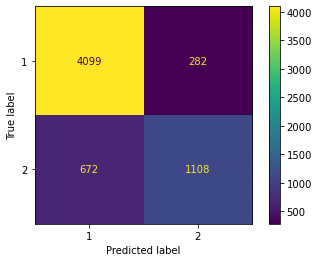

In [14]:
# plot the confusion matrix
y_pred = linear_svc.predict(X_test_new)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp

In [16]:
# Calculate feature importances using permutation importance
result = permutation_importance(linear_svc, X_test_new, y_test, n_repeats=5, random_state=1)
importance_df = pd.DataFrame({'feature': X.columns[selector.get_support()], 'importance': result.importances_mean})
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

In [17]:
importance_df

,feature,importance
0,AGE,0.038598
1,BEDROOMS,0.036066
2,COSTWATR,0.031943
3,ROOMS,0.017108
4,MARST_Married SP,0.015290
5,DENSITY,0.013245
6,HHINCOME,0.012206
7,COSTGAS,0.008148
8,MARST_Never married,0.000519
9,NCOUPLES,0.000390


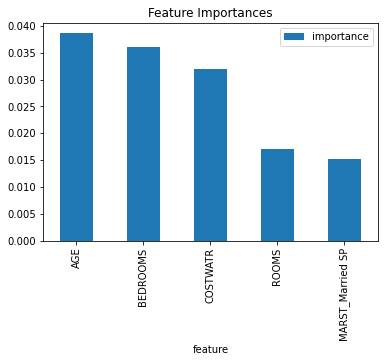

In [18]:
importance_df.iloc[:5].plot(kind='bar', x='feature', y='importance')
plt.title('Feature Importances')
plt.show()

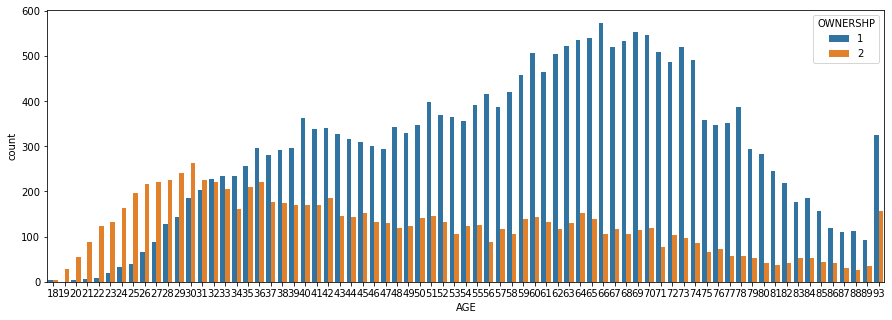

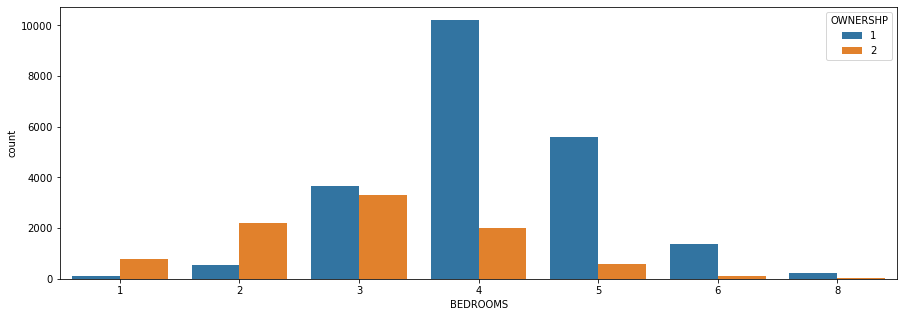

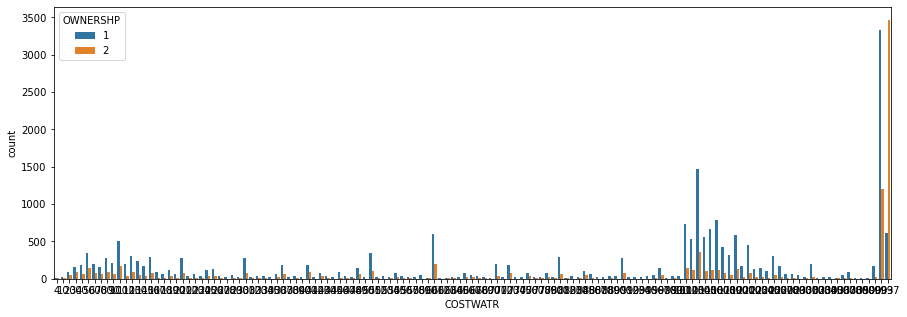

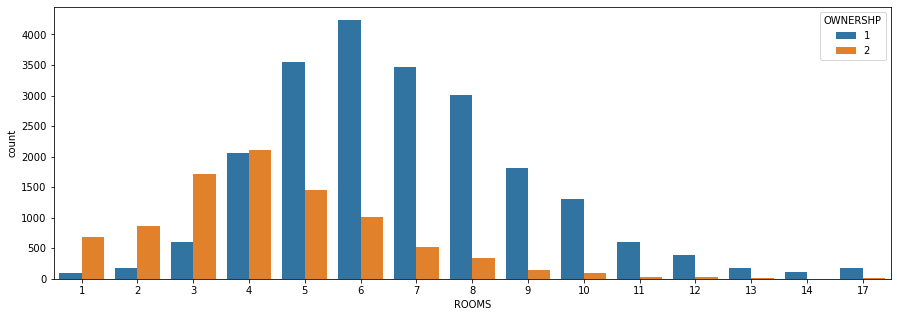

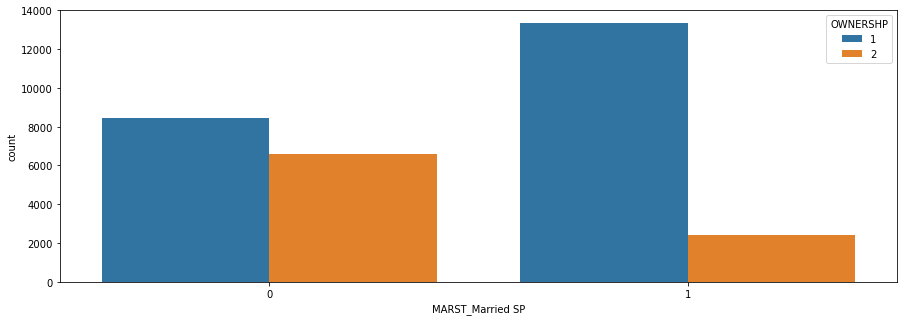

In [19]:
import seaborn as sns

# Get the top 5 important variables
top_5_vars = importance_df.iloc[:5]['feature'].tolist()

# Plot countplots for each of the top 5 variables
for var in top_5_vars:
    plt.figure(figsize=(15, 5))
    sns.countplot(x=var, hue='OWNERSHP', data=data)
    plt.show()

In [20]:
# Get the top 2 predictor variables
top_predictors = importance_df.head(2)['feature'].values
print("Top 2 predictwor variables:", top_predictors)

Top 2 predictwor variables: ['AGE' 'BEDROOMS']


[LibSVM]

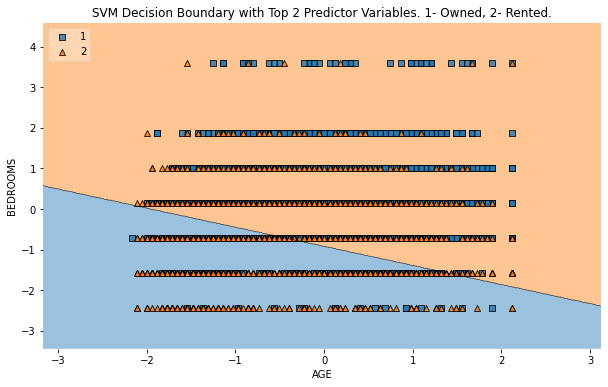

In [21]:
# Filter the dataset to keep only the top 2 predictor variables
X_top_predictors = X[top_predictors]

# Split the data into training and testing sets
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top_predictors, y, test_size=0.2, random_state=1)

# Scale the training and testing data
scaler_top = StandardScaler()
X_train_top_scaled = scaler_top.fit_transform(X_train_top)
X_test_top_scaled = scaler_top.transform(X_test_top)

# Train the best model with the top 2 predictor variables
linear_svc_top = SVC(kernel='linear', C=0.01, cache_size=1000, verbose=True, max_iter=10000, random_state=1)
linear_svc_top.fit(X_train_top_scaled, y_train_top)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plot_decision_regions(X_test_top_scaled, y_test_top.to_numpy(), clf=linear_svc_top, legend=2)
plt.xlabel(top_predictors[0])
plt.ylabel(top_predictors[1])
plt.title('SVM Decision Boundary with Top 2 Predictor Variables. 1- Owned, 2- Rented.')
plt.show()


## RADIAL

In [22]:
C_values = [0.01, 0.1, 1, 10, 100, 1000]
for C in C_values:
    radial_svc = SVC(kernel='rbf', gamma=1, C=C, cache_size=1000, verbose = True, max_iter = 1000, random_state=1)

    # Fit the model to the training data
    radial_svc.fit(X_train_scaled, y_train)

    # Evaluate the model on the testing data and print the accuracy score
    accuracy = radial_svc.score(X_test_scaled, y_test)
    print("Radial SVM with C=%s: %.2f%%" % (C, accuracy * 100))

[LibSVM]Radial SVM with C=0.01: 71.56%
[LibSVM]Radial SVM with C=0.1: 72.46%
[LibSVM]Radial SVM with C=1: 71.27%
[LibSVM]Radial SVM with C=10: 69.49%
[LibSVM]Radial SVM with C=100: 67.70%
[LibSVM]Radial SVM with C=1000: 67.70%


#### FEATURE SELECTION

In [23]:
# Perform feature selection
k = 10  # number of top features to select
selector = SelectKBest(f_classif, k=k)
selector.fit(X_train_scaled, y_train)
X_train_new = selector.transform(X_train_scaled)
X_test_new = selector.transform(X_test_scaled)

In [28]:
C_values = [0.01, 0.1, 1, 10, 100, 1000]

for C in C_values:
    radial_svc = SVC(kernel='rbf',gamma=1, C=C, cache_size=1000, verbose = True, max_iter = 10000, random_state=1)

    # Fit the model to the training data
    radial_svc.fit(X_train_new, y_train)

    # Evaluate the model on the testing data and print the accuracy score
    accuracy = radial_svc.score(X_test_new, y_test)
    print("Radial SVM with C=%s: %.2f%%" % (C, accuracy * 100))

[LibSVM]Radial SVM with C=0.01: 73.41%
[LibSVM]Radial SVM with C=0.1: 82.52%
[LibSVM]Radial SVM with C=1: 84.73%
[LibSVM]Radial SVM with C=10: 82.39%
[LibSVM]Radial SVM with C=100: 68.72%
[LibSVM]Radial SVM with C=1000: 70.28%


In [29]:
g_values = [0.01, 0.1, 1, 10]

for g in g_values:
    radial_svc = SVC(kernel='rbf',gamma=g, C=1, cache_size=1000, verbose = True, max_iter = 10000, random_state=1)

    # Fit the model to the training data
    radial_svc.fit(X_train_new, y_train)

    # Evaluate the model on the testing data and print the accuracy score
    accuracy = radial_svc.score(X_test_new, y_test)
    print("Radial SVM with gamma g=%s: %.2f%%" % (g, accuracy * 100))

[LibSVM]Radial SVM with gamma g=0.01: 84.29%
[LibSVM]Radial SVM with gamma g=0.1: 84.79%
[LibSVM]Radial SVM with gamma g=1: 84.73%
[LibSVM]Radial SVM with gamma g=10: 79.48%


Gamma = 0.1 and cost = 1 is giving the best result with accuracy 84.79%

In [30]:
radial_svc = SVC(kernel='rbf',gamma=0.1, C=1, cache_size=1000, verbose = True, max_iter = 10000, random_state=1)

# Fit the model to the training data
radial_svc.fit(X_train_new, y_train)

# Evaluate the model on the testing data and print the accuracy score
accuracy = radial_svc.score(X_test_new, y_test)
print("Radial SVM with gamma g= 0.1 and c = 1: %.2f%%" % (accuracy * 100))

[LibSVM]Radial SVM with gamma g= 0.1 and c = 1: 84.79%


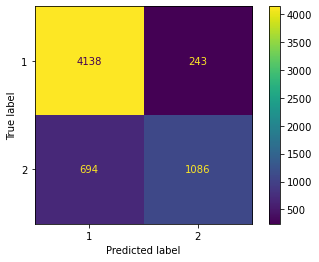

In [31]:
# plot the confusion matrix
y_pred = radial_svc.predict(X_test_new)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp

In [32]:
# Calculate feature importances using permutation importance
result = permutation_importance(radial_svc, X_test_new, y_test, n_repeats=5, random_state=1)
importance_df = pd.DataFrame({'feature': X.columns[selector.get_support()], 'importance': result.importances_mean})
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

In [33]:
importance_df

,feature,importance
0,BEDROOMS,0.040675
1,COSTWATR,0.038111
2,AGE,0.032397
3,ROOMS,0.024866
4,HHINCOME,0.010485
5,DENSITY,0.009998
6,COSTGAS,0.005551
7,MARST_Married SP,0.004902
8,NCOUPLES,0.001428
9,MARST_Never married,0.001006


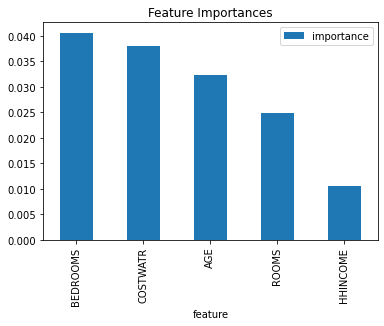

In [34]:
importance_df.iloc[:5].plot(kind='bar', x='feature', y='importance')
plt.title('Feature Importances')
plt.show()

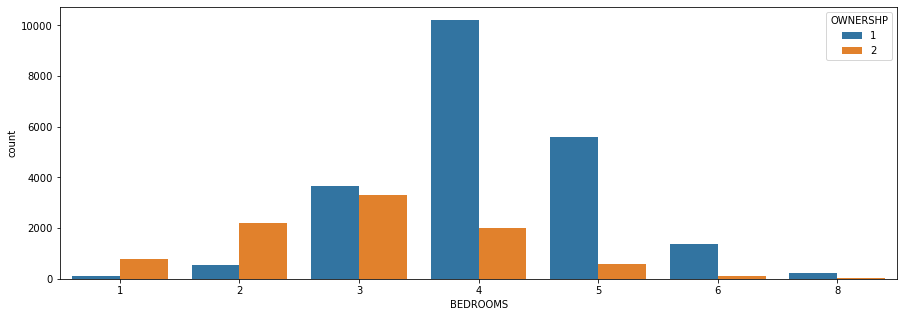

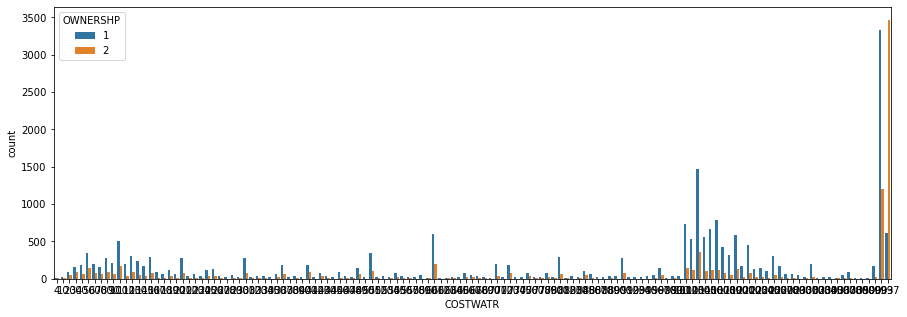

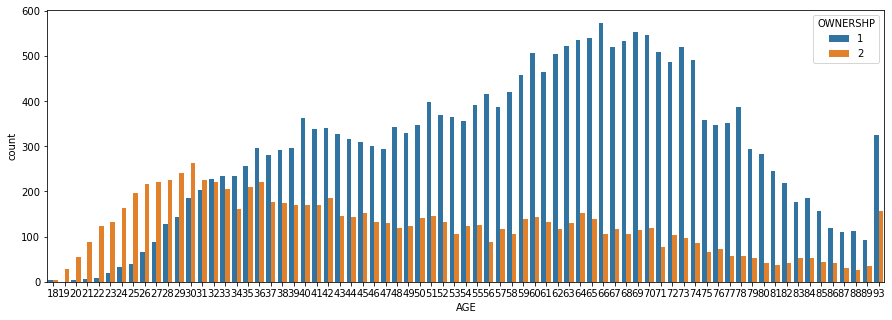

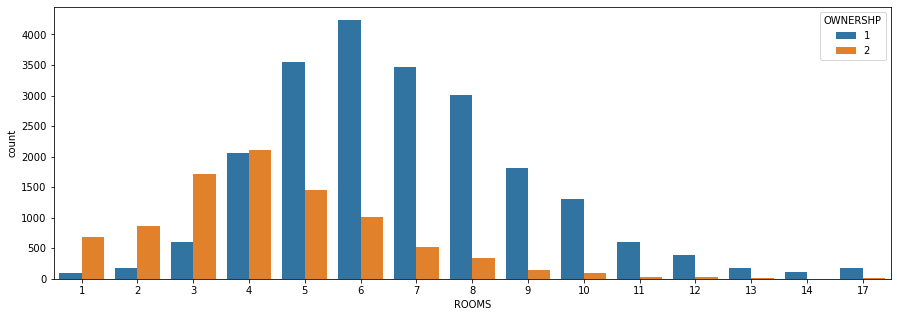

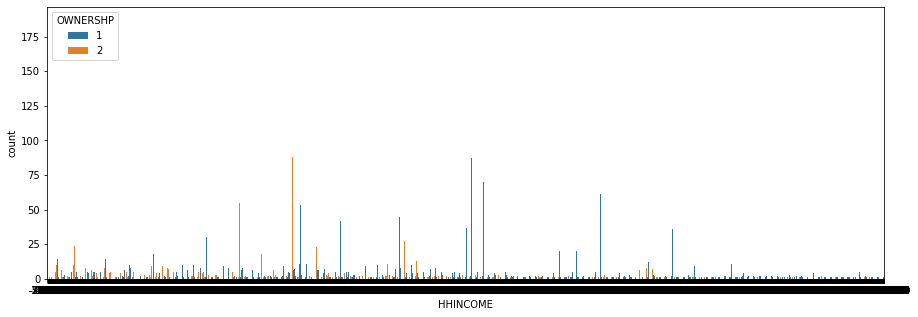

In [35]:
import seaborn as sns

# Get the top 5 important variables
top_5_vars = importance_df.iloc[:5]['feature'].tolist()

# Plot countplots for each of the top 5 variables
for var in top_5_vars:
    plt.figure(figsize=(15, 5))
    sns.countplot(x=var, hue='OWNERSHP', data=data)
    plt.show()

In [36]:
# Get the top 2 predictor variables
top_predictors = importance_df.head(2)['feature'].values
print("Top 2 predictor variables:", top_predictors)

Top 2 predictor variables: ['BEDROOMS' 'COSTWATR']


[LibSVM]

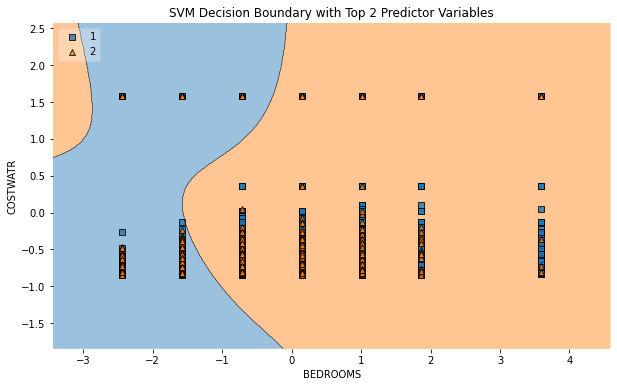

In [37]:
# Filter the dataset to keep only the top 2 predictor variables
X_top_predictors = X[top_predictors]

# Split the data into training and testing sets
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top_predictors, y, test_size=0.2, random_state=1)

# Scale the training and testing data
scaler_top = StandardScaler()
X_train_top_scaled = scaler_top.fit_transform(X_train_top)
X_test_top_scaled = scaler_top.transform(X_test_top)

# Train the best model with the top 2 predictor variables
radial_svc_top = SVC(kernel='rbf', C=1, gamma = 0.1, cache_size=1000, verbose=True, max_iter=10000, random_state=1)
radial_svc_top.fit(X_train_top_scaled, y_train_top)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plot_decision_regions(X_test_top_scaled, y_test_top.to_numpy(), clf=radial_svc_top, legend=2)
plt.xlabel(top_predictors[0])
plt.ylabel(top_predictors[1])
plt.title('SVM Decision Boundary with Top 2 Predictor Variables')
plt.show()

## POLYNOMIAL

In [38]:
C_values = [0.01, 0.1, 1, 10, 100, 1000]
for C in C_values:
    poly_svc = SVC(kernel='poly', degree=2, coef0=1, C=C, gamma='scale', cache_size=1000, verbose=True, max_iter=10000, random_state=1)

    # Fit the model to the training data
    poly_svc.fit(X_train_scaled, y_train)

    # Evaluate the model on the testing data and print the accuracy score
    accuracy = poly_svc.score(X_test_scaled, y_test)
    print("Polynomial SVM with C=%s: %.2f%%" % (C, accuracy * 100))

[LibSVM]Polynomial SVM with C=0.01: 85.16%
[LibSVM]Polynomial SVM with C=0.1: 85.73%
[LibSVM]Polynomial SVM with C=1: 85.94%
[LibSVM]Polynomial SVM with C=10: 55.06%
[LibSVM]Polynomial SVM with C=100: 32.92%
[LibSVM]Polynomial SVM with C=1000: 37.30%


### FEATURE SELECTION

In [39]:
# Perform feature selection
k = 10  # number of top features to select
selector = SelectKBest(f_classif, k=k)
selector.fit(X_train_scaled, y_train)
X_train_new = selector.transform(X_train_scaled)
X_test_new = selector.transform(X_test_scaled)

In [40]:
C_values = [0.01, 0.1, 1, 10, 100, 1000]

for C in C_values:
    poly_svc = SVC(kernel='poly', degree=2, coef0=1, C=C, gamma='scale', cache_size=1000, verbose=True, max_iter=10000, random_state=1)

    # Fit the model to the training data
    poly_svc.fit(X_train_new, y_train)

    # Evaluate the model on the testing data and print the accuracy score
    accuracy = poly_svc.score(X_test_new, y_test)
    print("Polynomial SVM with C=%s: %.2f%%" % (C, accuracy * 100))

[LibSVM]Polynomial SVM with C=0.01: 84.00%
[LibSVM]Polynomial SVM with C=0.1: 84.45%
[LibSVM]Polynomial SVM with C=1: 84.71%
[LibSVM]Polynomial SVM with C=10: 75.28%
[LibSVM]Polynomial SVM with C=100: 47.38%
[LibSVM]Polynomial SVM with C=1000: 60.88%


In [42]:
degree_values = [2,3,4]

for d in degree_values:
    poly_svc = SVC(kernel='poly', degree=d, coef0=1, C= 1 , gamma='scale', cache_size=1000, verbose=True, max_iter=10000, random_state=42)

    # Fit the model to the training data
    poly_svc.fit(X_train_new, y_train)

    # Evaluate the model on the testing data and print the accuracy score
    accuracy = poly_svc.score(X_test_new, y_test)
    print("Polynomial SVM with degree d = %s: %.2f%%" % (d, accuracy * 100))

[LibSVM]Polynomial SVM with degree d = 2: 84.45%
[LibSVM]Polynomial SVM with degree d = 3: 84.69%
[LibSVM]Polynomial SVM with degree d = 4: 85.03%


In [43]:
poly_svc = SVC(kernel='poly', degree=4 , coef0=1, C=0.1 , gamma='scale', cache_size=1000, verbose=True, max_iter=10000, random_state=42)

# Fit the model to the training data
poly_svc.fit(X_train_new, y_train)

# Evaluate the model on the testing data and print the accuracy score
accuracy = poly_svc.score(X_test_new, y_test)
print("Polynomial SVM with degree d = 4 and c = 0.1: %.2f%%" % (accuracy * 100))

[LibSVM]Polynomial SVM with degree d = 4 and c = 0.1: 85.03%


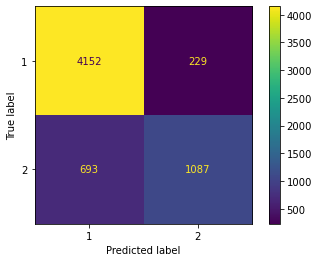

In [44]:
# plot the confusion matrix
y_pred = poly_svc.predict(X_test_new)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp

In [45]:
# Calculate feature importances using permutation importance
result = permutation_importance(poly_svc, X_test_new, y_test, n_repeats=10, random_state=1)
importance_df = pd.DataFrame({'feature': X.columns[selector.get_support()], 'importance': result.importances_mean})
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

In [46]:
importance_df

,feature,importance
0,COSTWATR,0.045967
1,AGE,0.039296
2,BEDROOMS,0.037494
3,ROOMS,0.027349
4,HHINCOME,0.013991
5,DENSITY,0.012579
6,COSTGAS,0.008213
7,MARST_Married SP,0.007596
8,NCOUPLES,0.003782
9,MARST_Never married,0.002386


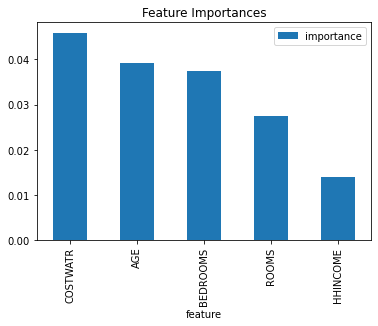

In [47]:
importance_df.iloc[:5].plot(kind='bar', x='feature', y='importance')
plt.title('Feature Importances')
plt.show()

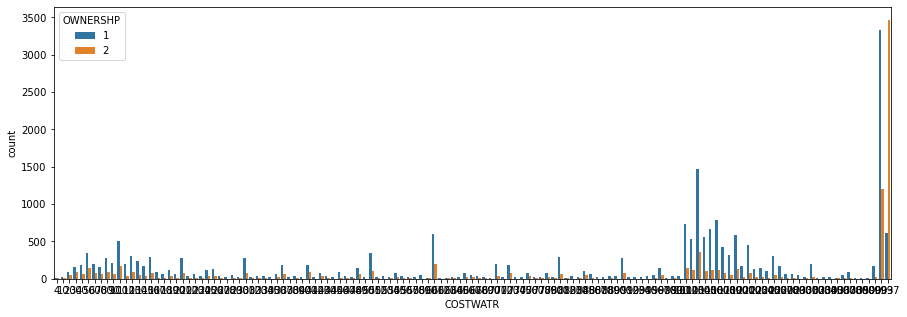

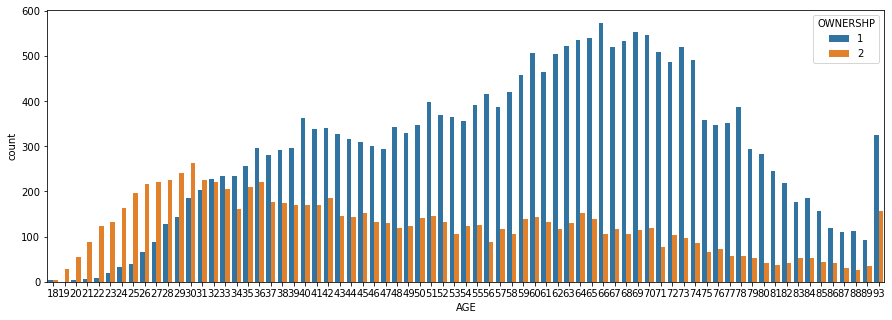

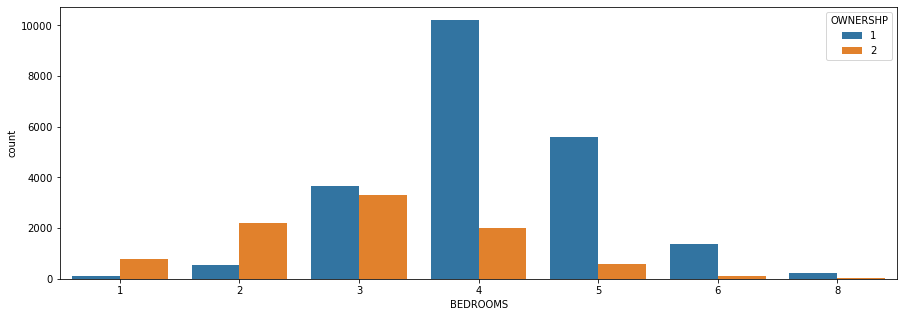

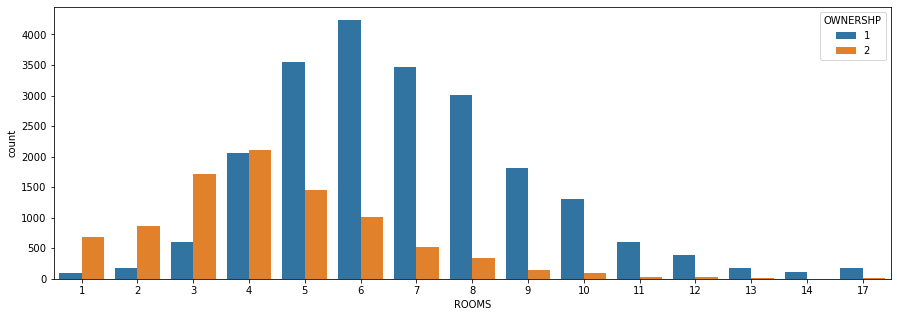

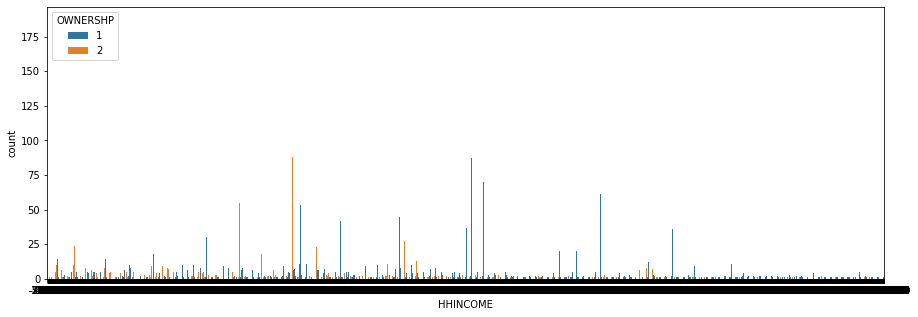

In [48]:
import seaborn as sns

# Get the top 5 important variables
top_5_vars = importance_df.iloc[:5]['feature'].tolist()

# Plot countplots for each of the top 5 variables
for var in top_5_vars:
    plt.figure(figsize=(15, 5))
    sns.countplot(x=var, hue='OWNERSHP', data=data)
    plt.show()

In [49]:
# Get the top 2 predictor variables
top_predictors = importance_df.head(2)['feature'].values
print("Top 2 predictor variables:", top_predictors)

Top 2 predictor variables: ['COSTWATR' 'AGE']


[LibSVM]

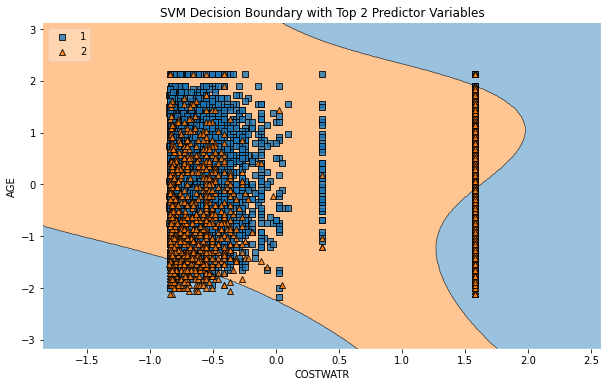

In [50]:
# Filter the dataset to keep only the top 2 predictor variables
X_top_predictors = X[top_predictors]

# Split the data into training and testing sets
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top_predictors, y, test_size=0.2, random_state=1)

# Scale the training and testing data
scaler_top = StandardScaler()
X_train_top_scaled = scaler_top.fit_transform(X_train_top)
X_test_top_scaled = scaler_top.transform(X_test_top)

# Train the best model with the top 2 predictor variables
poly_svc_top = SVC(kernel='poly', degree=4 , coef0=1, C=0.1 , gamma='scale', cache_size=1000, verbose=True, max_iter=10000, random_state=1)
poly_svc_top.fit(X_train_top_scaled, y_train_top)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plot_decision_regions(X_test_top_scaled, y_test_top.to_numpy(), clf=poly_svc_top, legend=2)
plt.xlabel(top_predictors[0])
plt.ylabel(top_predictors[1])
plt.title('SVM Decision Boundary with Top 2 Predictor Variables')
plt.show()